<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

In [ ]:
import fastai.losses as fl

In [ ]:
whatinside(fl)

fastai.losses has: 
11 items in its __all__, and 
334 user defined functions, 
178 classes or class objects, 
4 builtin funcs and methods, and
535 callables.

None


### ```BaseLoss()```
Same as `loss_cls`, but flattens input and target.

In [1]:
#|output: asis
#| echo: false
show_doc(BaseLoss)

---

[source](https://github.com/EmbraceLife/fastdebug/blob/master/fastdebug/losses.py#L15){target="_blank" style="float:right; font-size:smaller"}

### BaseLoss

>      BaseLoss (loss_cls, *args, axis:int=-1, flatten:bool=True,
>                floatify:bool=False, is_2d:bool=True, **kwargs)

Same as `loss_cls`, but flattens input and target.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| loss_cls |  |  | Uninitialized PyTorch-compatible loss |
| args |  |  |  |
| axis | int | -1 |  |
| flatten | bool | True |  |
| floatify | bool | False |  |
| is_2d | bool | True |  |
| kwargs |  |  |  |

Wrapping a general loss function inside of [`BaseLoss`](https://EmbraceLife.github.io/fastdebug/lib/src_fastai_losses.html#baseloss) provides extra functionalities to your loss functions:
- flattens the tensors before trying to take the losses since it's more convenient (with a potential tranpose to put `axis` at the end)
- a potential `activation` method that tells the library if there is an activation fused in the loss (useful for inference and methods such as `Learner.get_preds` or [`Learner.predict`](https://EmbraceLife.github.io/fastdebug/fastai_notebooks/fastai_is_it_a_bird.html#learner.predict))
- a potential <code>decodes</code> method that is used on predictions in inference (for instance, an argmax in classification)

The `args` and `kwargs` will be passed to `loss_cls` during the initialization to instantiate a loss function. `axis` is put at the end for losses like softmax that are often performed on the last axis. If `floatify=True`, the `targs` will be converted to floats (useful for losses that only accept float targets like `BCEWithLogitsLoss`), and `is_2d` determines if we flatten while keeping the first dimension (batch size) or completely flatten the input. We want the first for losses like Cross Entropy, and the second for pretty much anything else.

In [2]:
#|output: asis
#| echo: false
show_doc(CrossEntropyLossFlat)

---

[source](https://github.com/EmbraceLife/fastdebug/blob/master/fastdebug/losses.py#L62){target="_blank" style="float:right; font-size:smaller"}

### CrossEntropyLossFlat

>      CrossEntropyLossFlat (*args, axis:int=-1, weight=None, ignore_index=-100,
>                            reduction='mean', flatten:bool=True,
>                            floatify:bool=False, is_2d:bool=True)

Same as `nn.CrossEntropyLoss`, but flattens input and target.

In [ ]:
tst = CrossEntropyLossFlat(reduction='none')
output = torch.randn(32, 5, 10)
target = torch.randint(0, 10, (32,5))
#nn.CrossEntropy would fail with those two tensors, but not our flattened version.
_ = tst(output, target)

test_fail(lambda x: nn.CrossEntropyLoss()(output,target))

#Associated activation is softmax
test_eq(tst.activation(output), F.softmax(output, dim=-1))
#This loss function has a decodes which is argmax
test_eq(tst.decodes(output), output.argmax(dim=-1))

In [ ]:
#In a segmentation task, we want to take the softmax over the channel dimension
tst = CrossEntropyLossFlat(axis=1)
output = torch.randn(32, 5, 128, 128)
target = torch.randint(0, 5, (32, 128, 128))
_ = tst(output, target)

test_eq(tst.activation(output), F.softmax(output, dim=1))
test_eq(tst.decodes(output), output.argmax(dim=1))

[Focal Loss](https://arxiv.org/pdf/1708.02002.pdf) is the same as cross entropy except easy-to-classify observations are down-weighted in the loss calculation. The strength of down-weighting is proportional to the size of the `gamma` parameter. Put another way, the larger `gamma` the less the easy-to-classify observations contribute to the loss.

In [3]:
#|output: asis
#| echo: false
show_doc(FocalLossFlat)

---

[source](https://github.com/EmbraceLife/fastdebug/blob/master/fastdebug/losses.py#L104){target="_blank" style="float:right; font-size:smaller"}

### FocalLossFlat

>      FocalLossFlat (*args, gamma:float=2.0, axis:int=-1, weight=None,
>                     reduction='mean', **kwargs)

Same as CrossEntropyLossFlat but with focal paramter, `gamma`. Focal loss is introduced by Lin et al. 
https://arxiv.org/pdf/1708.02002.pdf. Note the class weighting factor in the paper, alpha, can be 
implemented through pytorch `weight` argument passed through to F.cross_entropy.

In [4]:
#|output: asis
#| echo: false
show_doc(FocalLoss)

---

[source](https://github.com/EmbraceLife/fastdebug/blob/master/fastdebug/losses.py#L82){target="_blank" style="float:right; font-size:smaller"}

### FocalLoss

>      FocalLoss (gamma:float=2.0, weight:Tensor=None, reduction:str='mean')

Same as `nn.Module`, but no need for subclasses to call `super().__init__`

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| gamma | float | 2.0 | Focusing parameter. Higher values down-weight easy examples' contribution to loss |
| weight | Tensor | None | Manual rescaling weight given to each class |
| reduction | str | mean | PyTorch reduction to apply to the output |

In [ ]:
#Compare focal loss with gamma = 0 to cross entropy
fl = FocalLossFlat(gamma=0)
ce = CrossEntropyLossFlat()
output = torch.randn(32, 5, 10)
target = torch.randint(0, 10, (32,5))
test_close(fl(output, target), ce(output, target))
#Test focal loss with gamma > 0 is different than cross entropy
fl = FocalLossFlat(gamma=2)
test_ne(fl(output, target), ce(output, target))

In [ ]:
#In a segmentation task, we want to take the softmax over the channel dimension
fl = FocalLossFlat(gamma=0, axis=1)
ce = CrossEntropyLossFlat(axis=1)
output = torch.randn(32, 5, 128, 128)
target = torch.randint(0, 5, (32, 128, 128))
test_close(fl(output, target), ce(output, target), eps=1e-4)
test_eq(fl.activation(output), F.softmax(output, dim=1))
test_eq(fl.decodes(output), output.argmax(dim=1))

In [5]:
#|output: asis
#| echo: false
show_doc(BCEWithLogitsLossFlat)

---

[source](https://github.com/EmbraceLife/fastdebug/blob/master/fastdebug/losses.py#L130){target="_blank" style="float:right; font-size:smaller"}

### BCEWithLogitsLossFlat

>      BCEWithLogitsLossFlat (*args, axis:int=-1, floatify:bool=True,
>                             thresh:float=0.5, weight=None, reduction='mean',
>                             pos_weight=None, flatten:bool=True,
>                             is_2d:bool=True)

Same as `nn.BCEWithLogitsLoss`, but flattens input and target.

In [ ]:
tst = BCEWithLogitsLossFlat()
output = torch.randn(32, 5, 10)
target = torch.randn(32, 5, 10)
#nn.BCEWithLogitsLoss would fail with those two tensors, but not our flattened version.
_ = tst(output, target)
test_fail(lambda x: nn.BCEWithLogitsLoss()(output,target))
output = torch.randn(32, 5)
target = torch.randint(0,2,(32, 5))
#nn.BCEWithLogitsLoss would fail with int targets but not our flattened version.
_ = tst(output, target)
test_fail(lambda x: nn.BCEWithLogitsLoss()(output,target))

tst = BCEWithLogitsLossFlat(pos_weight=torch.ones(10))
output = torch.randn(32, 5, 10)
target = torch.randn(32, 5, 10)
_ = tst(output, target)
test_fail(lambda x: nn.BCEWithLogitsLoss()(output,target))

#Associated activation is sigmoid
test_eq(tst.activation(output), torch.sigmoid(output))

In [6]:
#|output: asis
#| echo: false
show_doc(BCELossFlat)

---

[source](https://github.com/EmbraceLife/fastdebug/blob/master/fastdebug/losses.py#L156){target="_blank" style="float:right; font-size:smaller"}

### BCELossFlat

>      BCELossFlat (*args, axis:int=-1, floatify:bool=True, weight=None,
>                   reduction='mean')

Same as `nn.BCELoss`, but flattens input and target.

In [ ]:
tst = BCELossFlat()
output = torch.sigmoid(torch.randn(32, 5, 10))
target = torch.randint(0,2,(32, 5, 10))
_ = tst(output, target)
test_fail(lambda x: nn.BCELoss()(output,target))

In [7]:
#|output: asis
#| echo: false
show_doc(MSELossFlat)

---

[source](https://github.com/EmbraceLife/fastdebug/blob/master/fastdebug/losses.py#L167){target="_blank" style="float:right; font-size:smaller"}

### MSELossFlat

>      MSELossFlat (*args, axis:int=-1, floatify:bool=True, reduction='mean')

Same as `nn.MSELoss`, but flattens input and target.

In [ ]:
tst = MSELossFlat()
output = torch.sigmoid(torch.randn(32, 5, 10))
target = torch.randint(0,2,(32, 5, 10))
_ = tst(output, target)
test_fail(lambda x: nn.MSELoss()(output,target))

In [8]:
#|output: asis
#| echo: false
show_doc(L1LossFlat)

---

[source](https://github.com/EmbraceLife/fastdebug/blob/master/fastdebug/losses.py#L178){target="_blank" style="float:right; font-size:smaller"}

### L1LossFlat

>      L1LossFlat (*args, axis=-1, floatify=True, reduction='mean')

Same as `nn.L1Loss`, but flattens input and target.

In [9]:
#|output: asis
#| echo: false
show_doc(LabelSmoothingCrossEntropy)

---

[source](https://github.com/EmbraceLife/fastdebug/blob/master/fastdebug/losses.py#L188){target="_blank" style="float:right; font-size:smaller"}

### LabelSmoothingCrossEntropy

>      LabelSmoothingCrossEntropy (eps:float=0.1, weight:Tensor=None,
>                                  reduction:str='mean')

Same as `nn.Module`, but no need for subclasses to call `super().__init__`

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| eps | float | 0.1 | The weight for the interpolation formula |
| weight | Tensor | None | Manual rescaling weight given to each class passed to `F.nll_loss` |
| reduction | str | mean | PyTorch reduction to apply to the output |

In [ ]:
lmce = LabelSmoothingCrossEntropy()
output = torch.randn(32, 5, 10)
target = torch.randint(0, 10, (32,5))
test_close(lmce(output.flatten(0,1), target.flatten()), lmce(output.transpose(-1,-2), target))

On top of the formula we define:
- a `reduction` attribute, that will be used when we call `Learner.get_preds`
- `weight` attribute to pass to BCE.
- an `activation` function that represents the activation fused in the loss (since we use cross entropy behind the scenes). It will be applied to the output of the model when calling `Learner.get_preds` or [`Learner.predict`](https://EmbraceLife.github.io/fastdebug/fastai_notebooks/fastai_is_it_a_bird.html#learner.predict)
- a <code>decodes</code> function that converts the output of the model to a format similar to the target (here indices). This is used in [`Learner.predict`](https://EmbraceLife.github.io/fastdebug/fastai_notebooks/fastai_is_it_a_bird.html#learner.predict) and `Learner.show_results` to decode the predictions 

In [10]:
#|output: asis
#| echo: false
show_doc(LabelSmoothingCrossEntropyFlat)

---

[source](https://github.com/EmbraceLife/fastdebug/blob/master/fastdebug/losses.py#L217){target="_blank" style="float:right; font-size:smaller"}

### LabelSmoothingCrossEntropyFlat

>      LabelSmoothingCrossEntropyFlat (*args, axis:int=-1, eps=0.1,
>                                      reduction='mean', flatten:bool=True,
>                                      floatify:bool=False, is_2d:bool=True)

Same as [`LabelSmoothingCrossEntropy`](https://EmbraceLife.github.io/fastdebug/lib/src_fastai_losses.html#labelsmoothingcrossentropy), but flattens input and target.

In [ ]:
#These two should always equal each other since the Flat version is just passing data through
lmce = LabelSmoothingCrossEntropy()
lmce_flat = LabelSmoothingCrossEntropyFlat()
output = torch.randn(32, 5, 10)
target = torch.randint(0, 10, (32,5))
test_close(lmce(output.transpose(-1,-2), target), lmce_flat(output,target))

We present a general `Dice` loss for segmentation tasks. It is commonly used together with `CrossEntropyLoss` or [`FocalLoss`](https://EmbraceLife.github.io/fastdebug/lib/src_fastai_losses.html#focalloss) in kaggle competitions. This is very similar to the `DiceMulti` metric, but to be able to derivate through, we replace the `argmax` activation by a `softmax` and compare this with a one-hot encoded target mask. This function also adds a `smooth` parameter to help numerical stabilities in the intersection over union division. If your network has problem learning with this DiceLoss, try to set the `square_in_union` parameter in the DiceLoss constructor to `True`.

In [11]:
#|output: asis
#| echo: false
show_doc(DiceLoss)

---

[source](https://github.com/EmbraceLife/fastdebug/blob/master/fastdebug/losses.py#L236){target="_blank" style="float:right; font-size:smaller"}

### DiceLoss

>      DiceLoss (axis:int=1, smooth:float=1e-06, reduction:str='sum',
>                square_in_union:bool=False)

Dice loss for segmentation

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| axis | int | 1 | Class axis |
| smooth | float | 1e-06 | Helps with numerical stabilities in the IoU division |
| reduction | str | sum | PyTorch reduction to apply to the output |
| square_in_union | bool | False | Squares predictions to increase slope of gradients |

In [ ]:
dl = DiceLoss()
_x         = tensor( [[[1, 0, 2],
                       [2, 2, 1]]])
_one_hot_x = tensor([[[[0, 1, 0],
                       [0, 0, 0]],
                      [[1, 0, 0],
                       [0, 0, 1]],
                      [[0, 0, 1],
                       [1, 1, 0]]]])
test_eq(dl._one_hot(_x, 3), _one_hot_x)

In [ ]:
dl = DiceLoss()
model_output = tensor([[[[2., 1.],
                         [1., 5.]],
                        [[1,  2.],
                         [3., 1.]],
                        [[3., 0],
                         [4., 3.]]]])
target       =  tensor([[[2, 1],
                         [2, 0]]])
dl_out = dl(model_output, target)
test_eq(dl.decodes(model_output), target)

In [ ]:
dl = DiceLoss(reduction="mean")
#identical masks
model_output = tensor([[[.1], [.1], [100.]]])
target = tensor([[2]])
test_close(dl(model_output, target), 0)

#50% intersection
model_output = tensor([[[.1, 100.], [.1, .1], [100., .1]]])
target = tensor([[2, 1]])
test_close(dl(model_output, target), .66, eps=0.01)

As a test case for the dice loss consider satellite image segmentation. Let us say we have three classes: Background (0), River (1) and Road (2). Let us look at a specific target

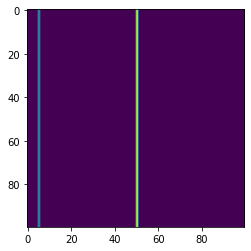

In [ ]:
target = torch.zeros(100,100)
target[:,5] = 1
target[:,50] = 2
plt.imshow(target);

Nearly everything is background in this example, and we have a thin river at the left of the image as well as a thin road in the middle of the image. If all our data looks similar to this, we say that there is a class imbalance, meaning that some classes (like river and road) appear relatively infrequently. If our model just predicted "background" (i.e. the value 0) for all pixels, it would be correct for most pixels. But this would be a bad model and the diceloss should reflect that

In [ ]:
model_output_all_background = torch.zeros(3, 100,100)
# assign probability 1 to class 0 everywhere
# to get probability 1, we just need a high model output before softmax gets applied
model_output_all_background[0,:,:] = 100

In [ ]:
# add a batch dimension
model_output_all_background = torch.unsqueeze(model_output_all_background,0)
target = torch.unsqueeze(target,0)

Our dice score should be around 1/3 here, because the "background" class is predicted correctly (and that for nearly every pixel), but the other two clases are never predicted correctly. Dice score of 1/3 means dice loss of 1 - 1/3 = 2/3:

In [ ]:
test_close(dl(model_output_all_background, target), 0.67, eps=0.01)

If the model would predict everything correctly, the dice loss should be zero:

In [ ]:
correct_model_output = torch.zeros(3, 100,100)
correct_model_output[0,:,:] = 100
correct_model_output[0,:,5] = 0
correct_model_output[0,:,50] = 0
correct_model_output[1,:,5] = 100
correct_model_output[2,:,50] = 100
correct_model_output = torch.unsqueeze(correct_model_output, 0)

In [ ]:
test_close(dl(correct_model_output, target), 0)

You could easily combine this loss with [`FocalLoss`](https://EmbraceLife.github.io/fastdebug/lib/src_fastai_losses.html#focalloss) defining a `CombinedLoss`, to balance between global (Dice) and local (Focal) features on the target mask.

In [ ]:
class CombinedLoss:
    "Dice and Focal combined"
    def __init__(self, axis=1, smooth=1., alpha=1.):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis)
        self.dice_loss =  DiceLoss(axis, smooth)
        
    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)
    
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [ ]:
cl = CombinedLoss()
output = torch.randn(32, 4, 5, 10)
target = torch.randint(0,2,(32, 5, 10))
_ = cl(output, target)